In [1]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, LSTM, Bidirectional, TimeDistributed, Reshape
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss, top_k_accuracy_score

/Users/lejohntanjunyen/Documents/Pattern_Recognition/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Extract and Load Data

In [2]:
annotation_file_path = "/Users/lejohntanjunyen/Documents/Pattern_Recognition/Pattern_Recognition/data/flickr_logos_27_dataset_training_set_annotation.txt"
annotationDF = pd.read_csv(annotation_file_path, 
                      sep="\s+", 
                      header=None, 
                      names=["image", "logo", "subset", "x1", "y1", "x2", "y2"])

<Figure size 1500x1000 with 0 Axes>

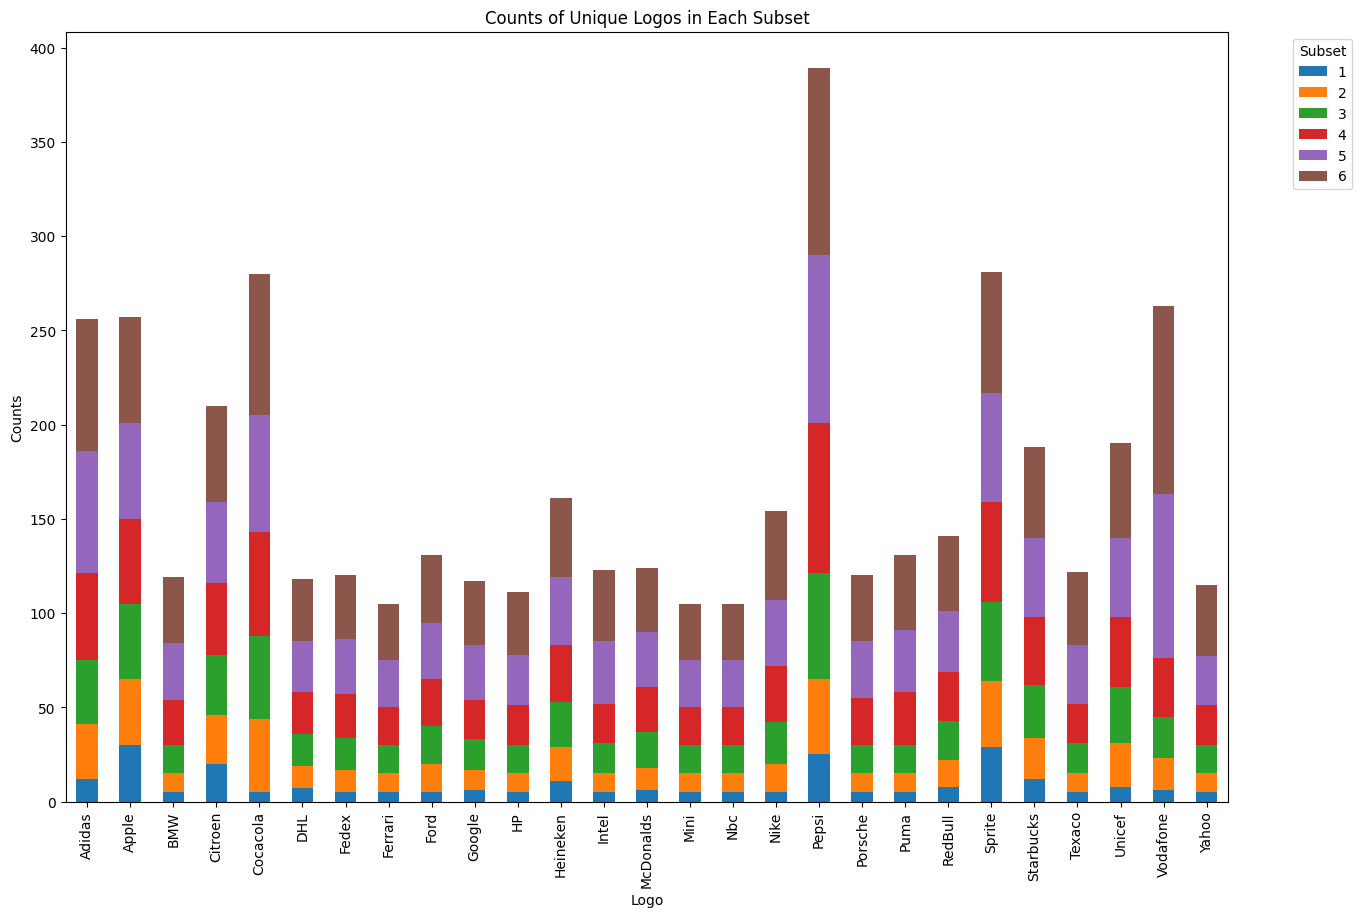

In [3]:
groupedDF = annotationDF.groupby(['logo', 'subset']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 10))
groupedDF.plot(kind='bar', stacked=True, figsize=(15, 10))
plt.title('Counts of Unique Logos in Each Subset')
plt.xlabel('Logo')
plt.ylabel('Counts')
plt.legend(title='Subset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### Before Preprocessing

In [4]:
images_dir = "/Users/lejohntanjunyen/Documents/Pattern_Recognition/Pattern_Recognition/data/flickr_logos_27_dataset_images"
sample_images = []
sample_image_file = []

for image in os.listdir(images_dir):
    image_path = os.path.join(images_dir, image)
    img = cv2.imread(image_path)
    sample_images.append(img)
    sample_image_file.append(image)

# Display the number of images and labels
print("Total images: {}".format(len(sample_images)))
print("Total labels: {}".format(len(sample_image_file)))

Total images: 1079
Total labels: 1079


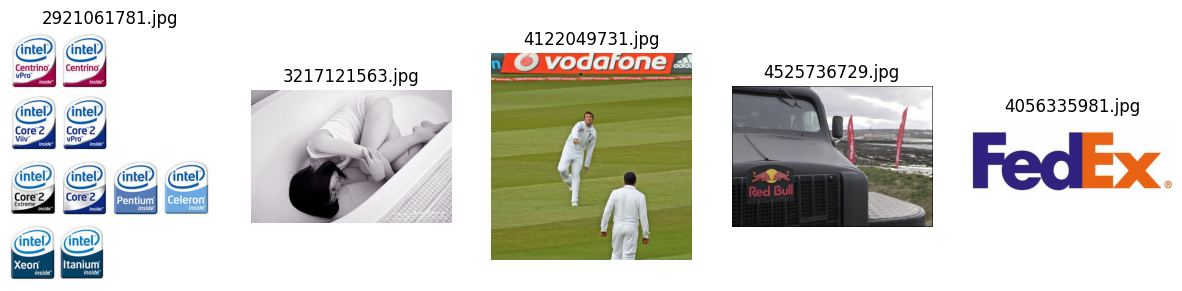

In [5]:
plt.figure(figsize=(15, 10))
random_indices = random.sample(range(len(sample_images)), 5)
for i, index in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(sample_images[index], cv2.COLOR_BGR2RGB))
    plt.title(sample_image_file[index])
    plt.axis('off')
plt.show()

### After Cropping

In [6]:
# Initialize lists to hold the cropped images and their labels
sample2 = []
sample_image2 = []

# Loop through the images in the directory
for image in os.listdir(images_dir):
    image_path = os.path.join(images_dir, image)
    img = cv2.imread(image_path)
    
    if img is not None:
        # Check if image in directory is in annotationDF (filter image with no label)
        if image not in annotationDF["image"]:
            print("[WARNING] Image: {} has no label.".format(image))

        # Get the annotations for this image
        image_annotations = annotationDF[annotationDF['image'] == image]
        
        # Loop through the annotations and crop the image accordingly
        for _, row in image_annotations.iterrows():
            x1, y1, x2, y2, logo = row['x1'], row['y1'], row['x2'], row['y2'], row['logo']
            cropped_img = img[y1:y2, x1:x2]
            
            sample2.append(cropped_img)
            sample_image2.append(logo)

# Display the number of images and labels
print("Total images: {}".format(len(sample2)))
print("Total labels: {}".format(len(sample_image2)))

[WARNING] Image: 3424492874.jpg has no label.
[WARNING] Image: 3950663671.jpg has no label.
[WARNING] Image: 239985057.jpg has no label.
[WARNING] Image: 4253102363.jpg has no label.
[WARNING] Image: 2767935306.jpg has no label.
[WARNING] Image: 4763209871.jpg has no label.
[WARNING] Image: 3418293624.jpg has no label.
[WARNING] Image: 4771736332.jpg has no label.
[WARNING] Image: 2855164257.jpg has no label.
[WARNING] Image: 2463686290.jpg has no label.
[WARNING] Image: 3177582448.jpg has no label.
[WARNING] Image: 3907306684.jpg has no label.
[WARNING] Image: 2618900486.jpg has no label.
[WARNING] Image: 4507852944.jpg has no label.
[WARNING] Image: 390297596.jpg has no label.
[WARNING] Image: 3270796445.jpg has no label.
[WARNING] Image: 3088579845.jpg has no label.
[WARNING] Image: 3820383802.jpg has no label.
[WARNING] Image: 3733440395.jpg has no label.
[WARNING] Image: 2866536247.jpg has no label.
[WARNING] Image: 2646033238.jpg has no label.
[WARNING] Image: 3667849273.jpg has 

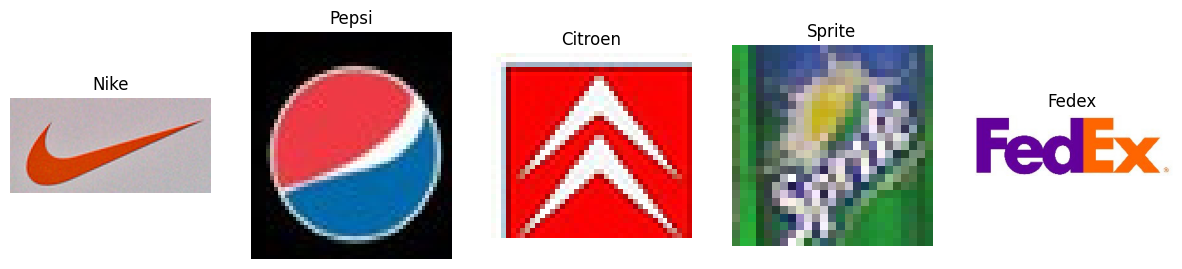

In [7]:
plt.figure(figsize=(15, 10))
random_indices = random.sample(range(len(sample2)), 5)
for i, index in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(sample2[index], cv2.COLOR_BGR2RGB))
    plt.title(sample_image2[index])
    plt.axis('off')
plt.show()

### After Cropping Adding PreProcessing

In [8]:
# Initialize lists to hold the cropped images and their labels
X = []
y = []

# Preprocessing functions
def preprocess_image(img):
    try:
        # Calculate padding to make the image square
        h, w = img.shape[:2]
        top, bottom, left, right = 0, 0, 0, 0
        if h > w:
            diff = h - w
            left = diff // 2
            right = diff - left
        else:
            diff = w - h
            top = diff // 2
            bottom = diff - top

        # Apply padding
        img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

        # Resize to a fixed size (e.g., 224x224)
        img = cv2.resize(img, (224, 224))

        # Normalize pixel values to range [0, 1]
        img = img / 255.0

        return img
    
    except cv2.error as e:
        print("[ERROR] Unable to resize image: {}".format(e))
        return None

# Loop through the images in the directory
for image in os.listdir(images_dir):
    image_path = os.path.join(images_dir, image)
    img = cv2.imread(image_path)

    if img is not None:
        # Get the annotations for this image
        image_annotations = annotationDF[annotationDF['image'] == image]

        # Loop through the annotations and crop the image accordingly
        for _, row in image_annotations.iterrows():
            x1, y1, x2, y2, logo = row['x1'], row['y1'], row['x2'], row['y2'], row['logo']

            if x1 < 0 or y1 < 0 or x2 > img.shape[1] or y2 > img.shape[0]:
                print("[WARNING] Invalid coordinates for image {}: ({}, {}, {}, {})".format(image, x1, y1, x2, y2))
                continue

            cropped_img = img[y1:y2, x1:x2]

            if cropped_img.size == 0:
                print("[WARNING] Cropped image: {} is empty for coordinates: ({}, {}, {}, {})".format(image, x1, y1, x2, y2))
                continue

            processed_img = preprocess_image(cropped_img)
            
            if processed_img is None:
                continue

            X.append(processed_img)
            y.append(logo)

try:
    X = np.array(X, dtype=np.float32)
    y = np.array(y)
except ValueError as e:
    print("[ERROR] Unable to convert lists to arrays: {}".format(e))

# Display the number of images and labels
print("Total images: {}".format(len(X)))
print("Total labels: {}".format(len(y)))

[WARNING] Cropped image: 2662264721.jpg is empty for coordinates: (3, 197, 3, 197)
[WARNING] Cropped image: 2662264721.jpg is empty for coordinates: (3, 197, 3, 197)
[WARNING] Cropped image: 2662264721.jpg is empty for coordinates: (3, 197, 3, 197)
[WARNING] Cropped image: 2662264721.jpg is empty for coordinates: (3, 197, 3, 197)
[WARNING] Cropped image: 2662264721.jpg is empty for coordinates: (3, 197, 3, 197)
Total images: 4531
Total labels: 4531


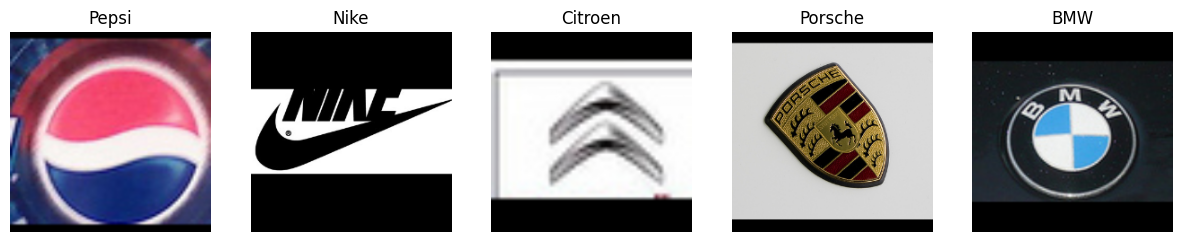

In [9]:
plt.figure(figsize=(15, 10))
random_indices = random.sample(range(len(X)), 5)
for i, index in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(X[index], cv2.COLOR_BGR2RGB))
    plt.title(y[index])
    plt.axis('off')
plt.show()

## Split Train Test Data

In [10]:
# Use LabelEncoder to convert string labels to integer labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [11]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

# Display the number of images and labels
print("Total images: {}".format(len(X)))
print("Total labels: {}".format(len(y)))
print("Training images: {}".format(len(X_train)))
print("Validation images: {}".format(len(X_val)))
print("Testing images: {}".format(len(X_test)))

Total images: 4531
Total labels: 4531
Training images: 2718
Validation images: 906
Testing images: 907


### Image Augmentation on Trainining Data

In [12]:
aug_train_images = []
aug_train_labels = []

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

for img, label in zip(X_train, y_train):
    processed_img2 = np.expand_dims(img, axis=0)
    aug_iter = datagen.flow(processed_img2, batch_size=1)
    aug_images = [next(aug_iter)[0].astype(np.float32)]  
    
    aug_train_images.append(img)
    aug_train_labels.append(label)
    
    for aug_img in aug_images:
        aug_train_images.append(aug_img)
        aug_train_labels.append(label)

aug_train_images = np.array(aug_train_images, dtype=np.float32)
aug_train_labels = np.array(aug_train_labels)

X_train_aug = aug_train_images
y_train_aug = aug_train_labels

print("Total training images after augmentation: {}".format(len(X_train)))
print("Total training labels after augmentation: {}".format(len(y_train)))

Total training images after augmentation: 2718
Total training labels after augmentation: 2718


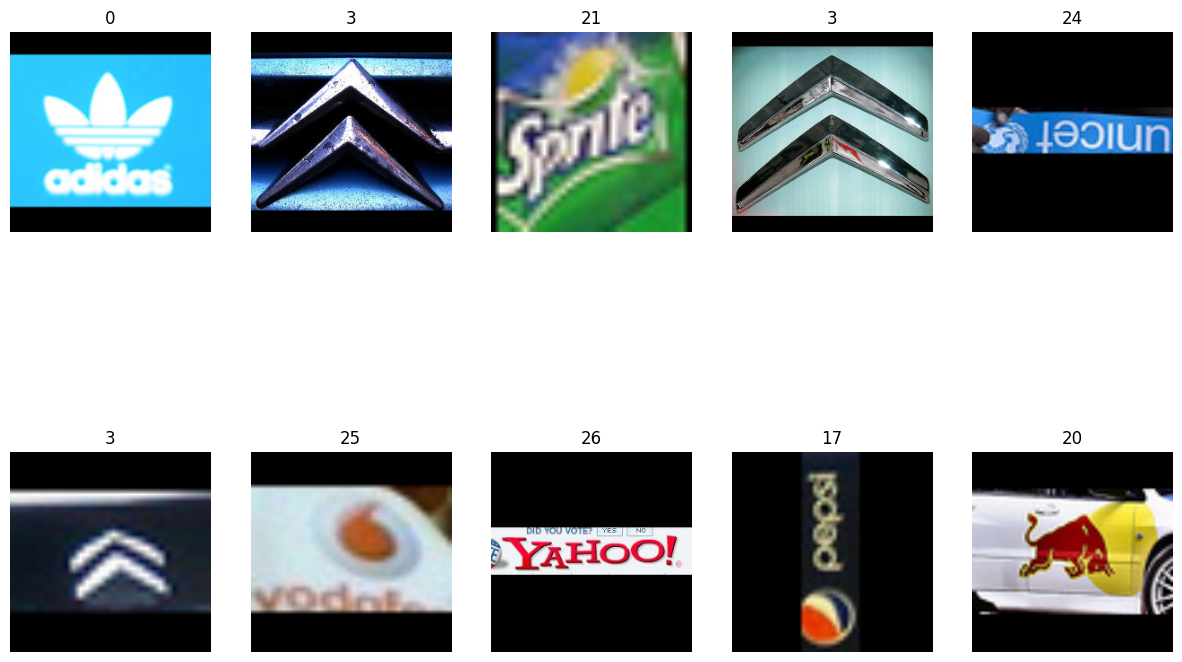

In [13]:
plt.figure(figsize=(15, 10))
random_indices = random.sample(range(len(X_train)), 10)
for i, index in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(cv2.cvtColor(X_train[index], cv2.COLOR_BGR2RGB))
    plt.title(y_train[index])
    plt.axis('off')
plt.show()

In [14]:
# Display the number of images and labels
print("Total images: {}".format(len(X)))
print("Total labels: {}".format(len(y)))
print("Training images: {}".format(len(X_train)))
print("Training labels: {}".format(len(y_train)))
print("Validation images: {}".format(len(X_val)))
print("Validation labels: {}".format(len(y_val)))
print("Testing images: {}".format(len(X_test)))
print("Testing labels: {}".format(len(y_test)))

Total images: 4531
Total labels: 4531
Training images: 2718
Training labels: 2718
Validation images: 906
Validation labels: 906
Testing images: 907
Testing labels: 907


### CNN Modelling

In [15]:
# Define layer sizes
L1 = 30
L2 = 30
L3 = 20

# Initialize the model
model = Sequential()

# Add an Input layer
model.add(Input(shape=(224, 224, 3)))

# Add layers to the model
model.add(Conv2D(L1, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l1(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(L2, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l1(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(L3, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l1(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(27, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer ='adam', metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 30)   │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 30)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 30)   │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 20)     │         5,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15680)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 27)             │       423,387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 437,777 (1.67 MB)

 Trainable params: 437,777 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
CNNtraining = model.fit(X_train_aug, y_train_aug, epochs=100, batch_size=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.2609 - loss: 3.8719 - val_accuracy: 0.7704 - val_loss: 1.8374
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.7441 - loss: 1.8675 - val_accuracy: 0.8620 - val_loss: 1.3801
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.8700 - loss: 1.2919 - val_accuracy: 0.9238 - val_loss: 1.1080
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9398 - loss: 0.9963 - val_accuracy: 0.9382 - val_loss: 1.0182
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9583 - loss: 0.8616 - val_accuracy: 0.9415 - val_loss: 0.9676
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9782 - loss: 0.7780 - val_accuracy: 0.9525 - val_loss: 0.9293
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9927 - loss: 0.6893 - val_accuracy: 0.9492 - val_loss: 0.9056
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9972 - loss: 0.6427 - val_accuracy: 0.9492 - v

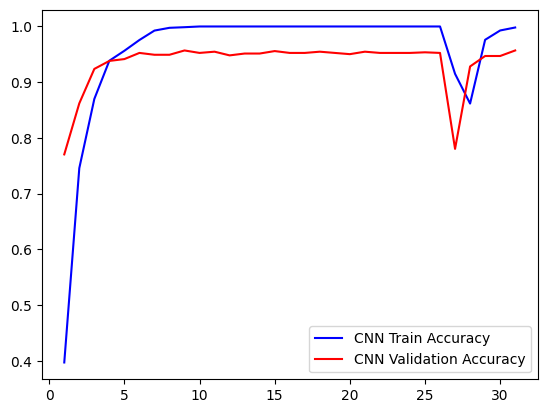

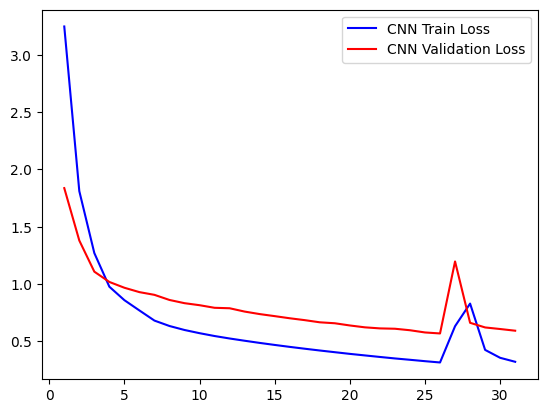

In [17]:
acc2 = CNNtraining.history['accuracy']
val_acc = CNNtraining.history['val_accuracy']
loss2 = CNNtraining.history['loss']
val_loss= CNNtraining.history['val_loss']

epochs =range(1,len(acc2)+1)
plt.plot(epochs, acc2,'b',label='CNN Train Accuracy')
plt.plot(epochs, val_acc,'r',label='CNN Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss2,'b',label='CNN Train Loss')
plt.plot(epochs,val_loss,'r',label='CNN Validation Loss')
plt.legend()
plt.show()

In [18]:
# Predict on test data
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = np.mean(y_pred_classes == y_test)
print("Accuracy on test set: {:.2f}".format(accuracy))

# Calculate precision
precision = precision_score(y_test, y_pred_classes, average='weighted')
print("Precision on test set: {:.2f}".format(precision))

# Calculate recall
recall = recall_score(y_test, y_pred_classes, average='weighted')
print("Recall on test set: {:.2f}".format(recall))

# Calculate F1 score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print("F1 Score on test set: {:.2f}".format(f1))

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
print("ROC-AUC on test set: {:.2f}".format(roc_auc))

# Calculate log loss
logloss = log_loss(y_test, y_pred)
print("Log Loss on test set: {:.2f}".format(logloss))

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step
Accuracy on test set: 0.95
Precision on test set: 0.95
Recall on test set: 0.95
F1 Score on test set: 0.95
ROC-AUC on test set: 1.00
Log Loss on test set: 0.29


### CNN Modelling + BiLSTM

In [19]:
# Define the CNN model
def create_cnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(20, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(20, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    return Model(inputs, x)

# Define the combined CNN-BiLSTM model
def create_hybrid_model(input_shape, num_classes):
    cnn_model = create_cnn_model(input_shape)
    
    # Convert CNN output to 3D tensor for RNN input
    cnn_out = cnn_model.output
    
    # Assuming the Flatten output shape to be (batch_size, features)
    # We need to reshape it to (batch_size, time_steps, features)
    time_steps = 4  # Arbitrary time_steps value (must fit the total size)
    features = cnn_out.shape[-1] // time_steps
    cnn_out_reshaped = Reshape((time_steps, features))(cnn_out)
    
    # BiLSTM
    rnn_out = Bidirectional(LSTM(32, return_sequences=False))(cnn_out_reshaped)
    rnn_out = Dropout(0.5)(rnn_out)
    
    # Fully connected layer
    output = Dense(num_classes, activation='softmax')(rnn_out)
    
    # Create the model
    model = Model(inputs=cnn_model.input, outputs=output)
    
    return model

input_shape = (224, 224, 3)
num_classes = 27

model = create_hybrid_model(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
CRNNtraining = model.fit(X_train_aug, y_train_aug, epochs=100, batch_size=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 544ms/step - accuracy: 0.0938 - loss: 3.1860 - val_accuracy: 0.2748 - val_loss: 2.7614
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 535ms/step - accuracy: 0.2402 - loss: 2.7907 - val_accuracy: 0.4150 - val_loss: 2.3008
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 548ms/step - accuracy: 0.3310 - loss: 2.4928 - val_accuracy: 0.4912 - val_loss: 1.9798
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 531ms/step - accuracy: 0.3836 - loss: 2.2024 - val_accuracy: 0.5706 - val_loss: 1.7208
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 528ms/step - accuracy: 0.4439 - loss: 2.0054 - val_accuracy: 0.6060 - val_loss: 1.5832
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 535ms/step - accuracy: 0.4731 - loss: 1.9180 - val_accuracy: 0.6512 - val_loss: 1.4548
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 527ms/step - accuracy: 0.5058 - loss: 1.7922 - val_accuracy: 0.6545 - val_loss: 1.3508
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 531ms/step - accuracy: 0.5395 - loss: 1.6960 - 

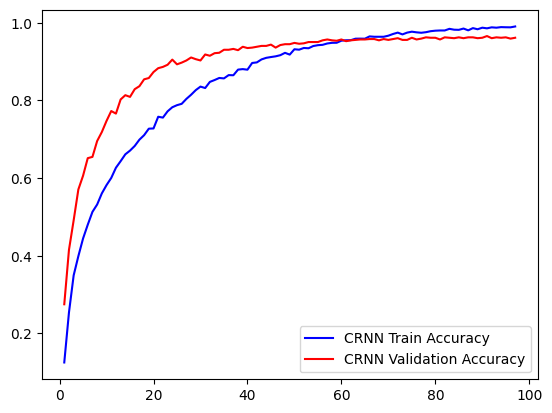

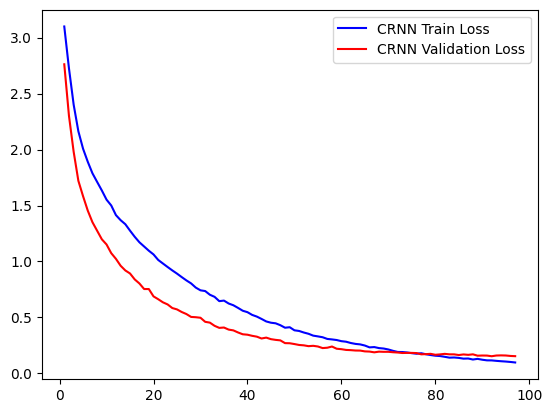

In [20]:
acc2 = CRNNtraining.history['accuracy']
val_acc = CRNNtraining.history['val_accuracy']
loss2 = CRNNtraining.history['loss']
val_loss= CRNNtraining.history['val_loss']

epochs =range(1,len(acc2)+1)
plt.plot(epochs, acc2,'b',label='CRNN Train Accuracy')
plt.plot(epochs, val_acc,'r',label='CRNN Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss2,'b',label='CRNN Train Loss')
plt.plot(epochs,val_loss,'r',label='CRNN Validation Loss')
plt.legend()
plt.show()

In [21]:
# Predict on test data
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = np.mean(y_pred_classes == y_test)
print("Accuracy on test set: {:.2f}".format(accuracy))

# Calculate precision
precision = precision_score(y_test, y_pred_classes, average='weighted')
print("Precision on test set: {:.2f}".format(precision))

# Calculate recall
recall = recall_score(y_test, y_pred_classes, average='weighted')
print("Recall on test set: {:.2f}".format(recall))

# Calculate F1 score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print("F1 Score on test set: {:.2f}".format(f1))

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
print("ROC-AUC on test set: {:.2f}".format(roc_auc))

# Calculate log loss
logloss = log_loss(y_test, y_pred)
print("Log Loss on test set: {:.2f}".format(logloss))

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Accuracy on test set: 0.95
Precision on test set: 0.95
Recall on test set: 0.95
F1 Score on test set: 0.95
ROC-AUC on test set: 1.00
Log Loss on test set: 0.19


In [22]:
# Define the CNN model
def create_cnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(40, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(40, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    return Model(inputs, x)

# Define the combined CNN-BiLSTM model
def create_hybrid_model(input_shape, num_classes):
    cnn_model = create_cnn_model(input_shape)
    
    # Convert CNN output to 3D tensor for RNN input
    cnn_out = cnn_model.output
    
    # Assuming the Flatten output shape to be (batch_size, features)
    # We need to reshape it to (batch_size, time_steps, features)
    time_steps = 4  # Arbitrary time_steps value (must fit the total size)
    features = cnn_out.shape[-1] // time_steps
    cnn_out_reshaped = Reshape((time_steps, features))(cnn_out)
    
    # BiLSTM
    rnn_out = Bidirectional(LSTM(64, return_sequences=False))(cnn_out_reshaped)
    rnn_out = Dropout(0.5)(rnn_out)
    
    # Fully connected layer
    output = Dense(num_classes, activation='softmax')(rnn_out)
    
    # Create the model
    model = Model(inputs=cnn_model.input, outputs=output)
    
    return model

input_shape = (224, 224, 3)  # Assuming RGB images
num_classes = 27

model = create_hybrid_model(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
CRNN3training = model.fit(X_train_aug, y_train_aug, epochs=100, batch_size=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.1263 - loss: 3.0929 - val_accuracy: 0.3389 - val_loss: 2.3295
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.3323 - loss: 2.3839 - val_accuracy: 0.5828 - val_loss: 1.7676
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.4525 - loss: 1.9787 - val_accuracy: 0.6137 - val_loss: 1.4533
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.5162 - loss: 1.7733 - val_accuracy: 0.7042 - val_loss: 1.2230
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.5862 - loss: 1.5203 - val_accuracy: 0.7362 - val_loss: 1.0578
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.6170 - loss: 1.3983 - val_accuracy: 0.7660 - val_loss: 0.9448
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.6625 - loss: 1.2512 - val_accuracy: 0.8124 - val_loss: 0.8568
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.6758 - loss: 1.1594 - val_accuracy: 0.8311 - v

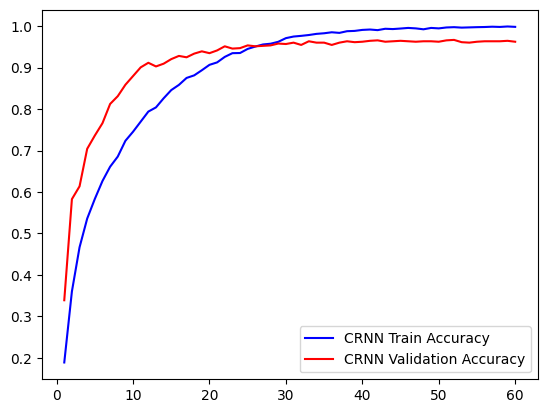

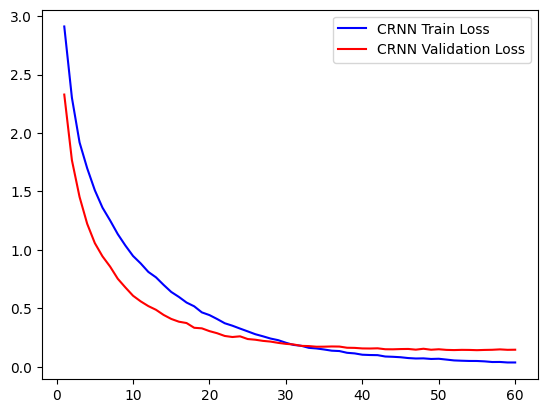

In [23]:
acc2 = CRNN3training.history['accuracy']
val_acc = CRNN3training.history['val_accuracy']
loss2 = CRNN3training.history['loss']
val_loss= CRNN3training.history['val_loss']

epochs =range(1,len(acc2)+1)
plt.plot(epochs, acc2,'b',label='CRNN Train Accuracy')
plt.plot(epochs, val_acc,'r',label='CRNN Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss2,'b',label='CRNN Train Loss')
plt.plot(epochs,val_loss,'r',label='CRNN Validation Loss')
plt.legend()
plt.show()

In [24]:
# Predict on test data
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = np.mean(y_pred_classes == y_test)
print("Accuracy on test set: {:.2f}".format(accuracy))

# Calculate precision
precision = precision_score(y_test, y_pred_classes, average='weighted')
print("Precision on test set: {:.2f}".format(precision))

# Calculate recall
recall = recall_score(y_test, y_pred_classes, average='weighted')
print("Recall on test set: {:.2f}".format(recall))

# Calculate F1 score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print("F1 Score on test set: {:.2f}".format(f1))

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
print("ROC-AUC on test set: {:.2f}".format(roc_auc))

# Calculate log loss
logloss = log_loss(y_test, y_pred)
print("Log Loss on test set: {:.2f}".format(logloss))

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step
Accuracy on test set: 0.96
Precision on test set: 0.96
Recall on test set: 0.96
F1 Score on test set: 0.96
ROC-AUC on test set: 1.00
Log Loss on test set: 0.17


### ResNet Modelling

In [25]:
base_layer = ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
)

model = Sequential([
    base_layer,
    Flatten(),
    Dense(512,activation="relu"),
    BatchNormalization(),
    Dense(1024,activation="relu"),
    Dropout(0.45),
    BatchNormalization(),
    Dense(2048,activation="relu"),
    Dropout(0.4),
    BatchNormalization(),
    Dense(1024,activation="relu"),
    Dropout(0.35),
    BatchNormalization(),
    Dense(len(y),activation="softmax")
])

model.compile(loss='sparse_categorical_crossentropy', optimizer ='adam', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', patience = 1, verbose = 1, factor = 0.25, mode="min")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [26]:
history = model.fit(
    X_train_aug, y_train_aug,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr]
)

Epoch 1/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 754s 9s/step - accuracy: 0.4388 - loss: 4.3876 - val_accuracy: 0.0000e+00 - val_loss: 43.8738 - learning_rate: 0.0010
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 735s 9s/step - accuracy: 0.8442 - loss: 0.6061 - val_accuracy: 0.0342 - val_loss: 6.9215 - learning_rate: 0.0010
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 726s 9s/step - accuracy: 0.9247 - loss: 0.2664 - val_accuracy: 0.0563 - val_loss: 5.7669 - learning_rate: 0.0010
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9502 - loss: 0.1612
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
85/85 ━━━━━━━━━━━━━━━━━━━━ 730s 9s/step - accuracy: 0.9502 - loss: 0.1612 - val_accuracy: 0.0331 - val_loss: 9.1239 - learning_rate: 0.0010
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9804 - loss: 0.0643
Epoch 5: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
85/85 ━━━━━━━━━━━━━━━━━━━━ 724s 9s/step - accuracy: 0.9805 - loss: 0.0641 - val_accur

In [27]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy: {:.2f}%".format(accuracy*100))

29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 693ms/step - accuracy: 0.9928 - loss: 0.0353
Test Accuracy: 99.45%


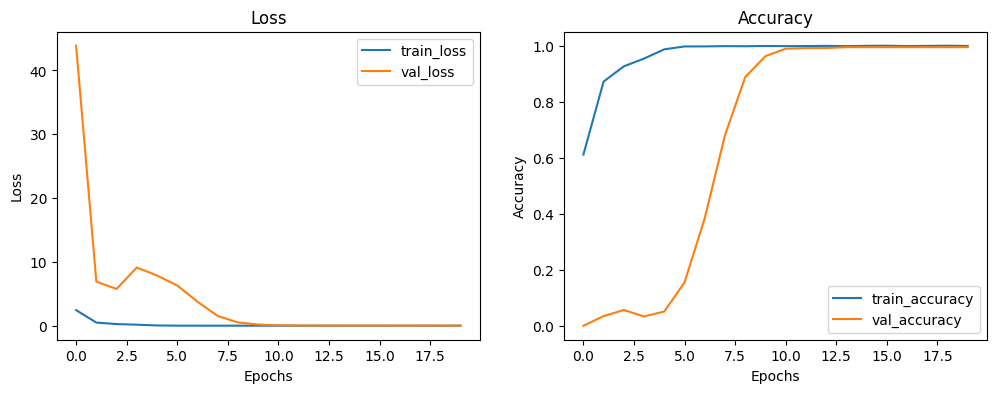

In [28]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Save ResNet Model

In [31]:
# model.save('resnet.h5')
model.save('resnet.keras')